In [8]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [9]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize

import torch
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
from head import InputTransform, Grid 
from apdist import AmplitudePhaseDistance as dist 

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight'
              } 

In [10]:
TARGET_SHAPE = 'Easy'

if TARGET_SHAPE=='Easy':
    target = [6.2,3.6]
    target_spectra = np.asarray(pd.read_excel('./exptdata/Target_Easy.xlsx'))
elif TARGET_SHAPE=='Hard':
    target = [0,0]
    target_spectra = np.asarray(pd.read_excel('./exptdata/Target_Hard.xlsx'))   
AG = [0,7.38] 
AA = [0,7.27]
bounds = [AG, AA]
bounds_params = torch.tensor(bounds).T.to(**tkwargs)
inp = InputTransform(bounds_params)

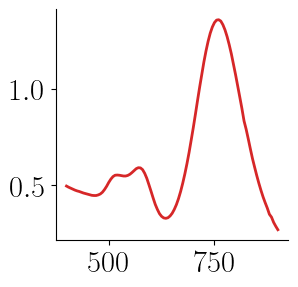

In [11]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.plot(target_spectra[:,0], target_spectra[:,1], lw=2.0, color="tab:red")
    plt.savefig("../figures/target.png")
    plt.show()

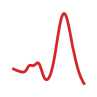

In [12]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(1,1))
    ax.plot(target_spectra[:,0], target_spectra[:,1], lw=2.0, color="tab:red")
    ax.axis('off')
    plt.savefig("../figures/target_tiny.png")
    plt.show()

In [13]:
def inset_spectra(loc,data, ax, **kwargs):
    loc_ax = ax.transLimits.transform(loc)
    ins_ax = ax.inset_axes([loc_ax[0]-0.05,loc_ax[1]-0.05,0.2,0.2])
    ins_ax.plot(target_spectra[:,0], data, **kwargs)
    ins_ax.axis('off')

    return 

class MinMaxScaler:
    def __init__(self, min, max):
        self.min = min 
        self.max = max 
        self.range = max-min

    def transform(self, x):
        return (x-self.min)/self.range
    
    def inverse(self, xt):
        return (self.range*xt)+self.min

def scaled_tickformat(scaler, x, pos):
    return '%.1f'%scaler.inverse(x)
    
class Visualize:
    def __init__(self, directory):
        self.dir = directory
        self.min_postmean = {}
        
    def get_model(self, iteration):
        idirec = self.dir + '/%d'%iteration 
        self.train_x = torch.from_numpy(np.load(idirec+'/train_x.npy')).to(**tkwargs)
        self.train_obj = torch.from_numpy(np.load(idirec+'/train_obj.npy')).to(**tkwargs)
        model = SingleTaskGP(self.train_x, self.train_obj, 
                    outcome_transform=Standardize(m=self.train_obj.shape[-1]))
        state_dict = torch.load(idirec+'/model.pth')
        model.load_state_dict(state_dict)
        self.model = model
        try:
            self.best_estimate = pd.read_excel(self.dir+'/Best_Estimate_%d.xlsx'%(iteration))
        except:
            self.best_estimate = None
    
        with torch.no_grad():
            self.n_grid = 20
            mu_grid = np.linspace(*bounds[0], num=self.n_grid)
            sig_grid = np.linspace(*bounds[1], num=self.n_grid)
            self.XX, self.YY = np.meshgrid(mu_grid, sig_grid)
            self.test_x = np.vstack([self.XX.ravel(), self.YY.ravel()]).T 
            self.test_x_t = inp.transform(torch.tensor(self.test_x).to(**tkwargs))
            posterior = self.model.posterior(self.test_x_t)
            self.posterior_mean = posterior.mean.cpu().numpy()
            lower, upper = posterior.mvn.confidence_region()
            self.confidence = np.abs((lower-upper).numpy())
        
        self.min_postmean[iteration] = self.posterior_mean.min()
        
        return 
    
    def add_collected_points(self, ax, **kwargs):
        train_x_unscaled = inp.inverse(self.train_x)
        points = ax.scatter(train_x_unscaled[:,0], train_x_unscaled[:,1], 
                   marker='o', fc='none', edgecolors=kwargs.get("edgecolors", "k"), 
                   lw=2.0)
        
        return points        
    
    def add_gp_mean(self, ax, **kwargs):
        Z =  self.posterior_mean.reshape(self.n_grid, self.n_grid)
        mean = ax.contourf(self.XX, self.YY, Z, **kwargs)

        return mean
    
    def add_gp_var(self, ax, **kwargs):
        Z = self.confidence.reshape(self.n_grid, self.n_grid)
        var = ax.contourf(self.XX, self.YY, Z, **kwargs)

        return var  

    def add_distance_values(self, ax, **kwargs):
        train_x_unscaled = inp.inverse(self.train_x) 
        for i in range(len(train_x_unscaled)):
            annotate_value = "%.2f"%np.abs(self.train_obj[i]) 
            ax.text(train_x_unscaled[i,0], train_x_unscaled[i,1], annotate_value) 
    
    def add_collected_spectra(self, iteration, ax, **kwargs):
        scaler_x = MinMaxScaler(bounds[0][0], bounds[0][1])
        scaler_y = MinMaxScaler(bounds[1][0], bounds[1][1])
        idirec = self.dir + '/%d'%(iteration-1)
        iter_spectra = pd.read_excel(idirec+'.xlsx')
        iter_comps = np.load(self.dir + '/%d'%(iteration-1) +'/new_x.npy')
        AG_x = iter_comps[:,0]*0.00064/350*10**5
        AA_x = iter_comps[:,1]*0.00630/350*10**4
        iter_comps = np.hstack((AG_x.reshape(-1,1)-0.1, AA_x.reshape(-1,1)-0.1))
        for ind,comp in enumerate(iter_comps):
            norm_ci = np.array([scaler_x.transform(comp[0]), scaler_y.transform(comp[1])]) 
            inset_spectra(norm_ci, iter_spectra.iloc[:,ind+1], ax, color=kwargs.get("color", "k"), lw=2.0)
      
        return ax 
    
    def _add_colorbar(self, mappable, fig, ax):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        cbar = fig.colorbar(mappable, cax=cax)

        return cbar

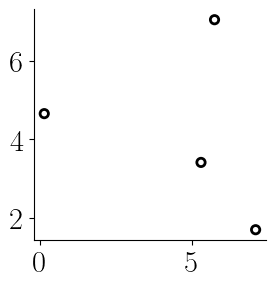

In [14]:
viz = Visualize('./exptdata/data_AP_%s'%TARGET_SHAPE) 
ITERATION = 1
viz.get_model(ITERATION)

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(3,3))
    viz.add_collected_points(ax) 
    plt.savefig("../figures/A%d.png"%ITERATION)
    plt.show()

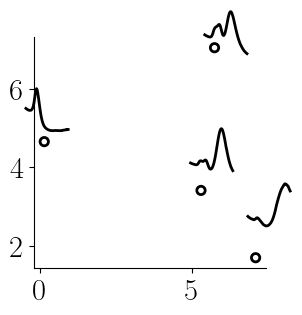

In [15]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(3,3))
    viz.add_collected_spectra(ITERATION, ax)
    viz.add_collected_points(ax)
    plt.savefig("../figures/B%d.png"%ITERATION)
    plt.show()

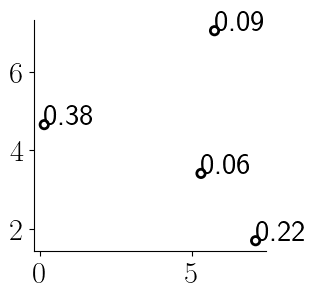

In [16]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(3,3))
    viz.add_distance_values(ax)
    viz.add_collected_points(ax)
    plt.savefig("../figures/C%d.png"%ITERATION)
    plt.show()

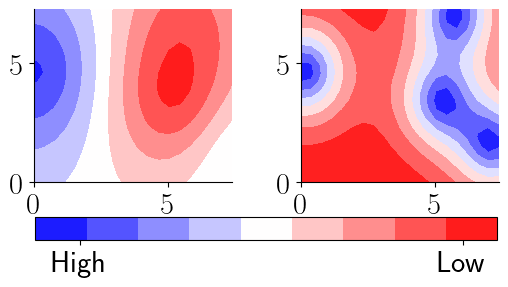

In [17]:
with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(1,2, figsize=(3*2,3))
    fig.subplots_adjust(wspace=0.35)
    im1 = viz.add_gp_mean(axs[0], cmap="bwr")
    im2 = viz.add_gp_var(axs[1], cmap="bwr")
    cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=.1, ticks=[viz.posterior_mean.min(), viz.posterior_mean.max()])
    cbar.ax.set_xticklabels(["High", "Low"])  # vertically oriented colorbar
    plt.savefig("../figures/D%d.png"%ITERATION)
    plt.show()